## Generate Light Curve
$SF_\infty = \hat{\sigma} \sqrt{\tau}$ and $\sigma = \hat{\sigma} \sqrt{\tau / 2} = SF_\infty / \sqrt{2}$.

In [1]:
import numpy as np

# set parameters
tau = 100 #signal decorrelation timescale in days
sf = 0.2
sigma_hat = sf/np.sqrt(tau) # modified variability amplitude
sigma = sf/np.sqrt(2)
delta_t = 0.5 # observational cadence delta_t = t_i+1 - t_i in days
duration = 4000 # in days
mean_mag = 18
n_epochs = int(duration/delta_t)
s = np.zeros(n_epochs)
ts = np.zeros(n_epochs)

for t in range(0,n_epochs):
    if t == 0:
        s[t] = np.random.normal(loc=0,scale=sigma) #for the 0th point, draw from Gaussian deviate of width sigma
        ts[t] = t*delta_t 
        # print('Here! t = ' + str(t))
    else:
        s[t] = s[t-1]*np.exp(-delta_t/tau) + np.random.normal(loc=0,scale=sigma*np.sqrt(1-np.exp(-2*delta_t/tau)))
        ts[t] = t*delta_t
        # print('Here! t = ' + str(t))

photometric_noise = np.random.normal(loc=0,scale=0.01,size=len(s))
# light curve is actually s + Gaussian noise + mean magnitude
y = s + mean_mag + photometric_noise

## Plot DRW Light Curve

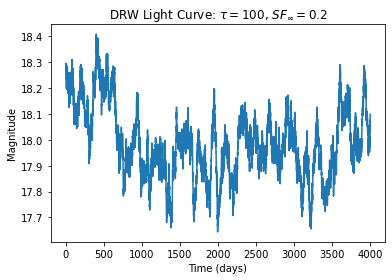

In [2]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(ts,y)
plt.xlabel('Time (days)')
plt.ylabel('Magnitude')
plt.title('DRW Light Curve: $\\tau = {}$'.format(tau) + ', $SF_\\infty = {}$'.format(sf))

plt.show()
# plt.savefig("Report Figures/drw-light-curve.pdf", bbox_inches='tight')


## Export to .dat
Three column format with (1) epoch, (2) magnitude/light curve value and (3) uncertainty on point.

In [3]:
import struct
import pandas as pd

# units in days
cadences = [5] #[0.5,1,2,3,5,10]
seasonal_gap = 100
durations = [40*tau]#[tau/2,tau,2*tau,5*tau,10*tau,20*tau,40*tau]

# apply duration limit in days (slice)
for d in durations:
    ts_sliced = ts[0:int(d/delta_t)]
    y_sliced = y[0:int(d/delta_t)]
    photometric_noise_sliced = photometric_noise[0:int(d/delta_t)]

    # apply cadence
    for c in cadences:
        # depending on cadence, sample every nth step from the sliced curve
        ts_cadenced = ts_sliced[0::int(c/delta_t)]
        y_cadenced = y_sliced[0::int(c/delta_t)]
        photometric_noise_cadenced = photometric_noise_sliced[
            0::int(c/delta_t)]
        
        # final data to be saved
        ts_final = ts_cadenced
        y_final = y_cadenced
        photometric_noise_final = photometric_noise_cadenced
        
        the_data = np.zeros((len(ts_final),3))
        the_data[:,0] = ts_final
        the_data[:,1] = y_final
        the_data[:,2] = photometric_noise_final

        df = pd.DataFrame(the_data)
        df.to_csv(
            'DRW Results/' + 'curve-d' + str(d) + '-c' +
            str(c) + '.dat', header=False, index=False, sep=' ')

# apply windowing
## after 100 days, remove data for 100 days, then resume
# ts_reshaped = np.reshape(ts, (int(duration/season), int(season/cadence)))
# for w in range(0,len(ts)):

## Interpret Light Curve with JAVELIN
### Plot the Curve with JAVELIN

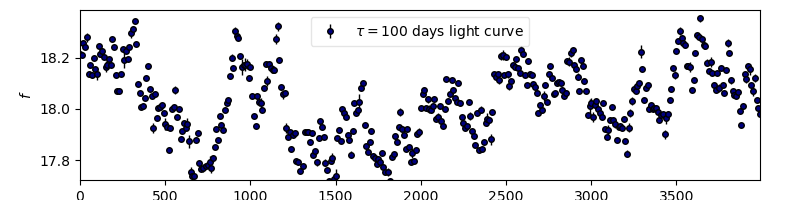

True

In [5]:
from javelin.zylc import get_data
javdata = get_data(
    ["DRW Results/curve-d4000-c10" + ".dat"],
     names=["$\\tau = 100$ days light curve",])
javdata.plot()

### MCMC the Light Curve

In [44]:
from javelin.lcmodel import Cont_Model
from javelin.zylc import get_data

tau = 100

# for c in [1]:
c=3
d = 40*tau
# for d in [20*tau]:
    
javdata = get_data(
    ["DRW Results/curve-d" + str(d) + "-c" + str(c) + ".dat"],
    names=["$\\tau = 100$ days light curve", ])

cont = Cont_Model(javdata)
cont.do_mcmc(
    fchain="DRW Results/" + "chain-d" + str(d) + "-c" + str(c) + ".dat",
    flogp="DRW Results/logp" + "-d" + str(d) + "-c" + str(c) + ".dat",
    threads=8)


start burn-in
nburn: 50 nwalkers: 100 --> number of burn-in iterations: 5000
burn-in finished
start sampling
sampling finished
acceptance fractions for all walkers are
0.80 0.74 0.72 0.76 0.72 0.76 0.66 0.58 0.64 0.76 0.60 0.66 0.72 0.72 0.74 0.74 0.64 0.70 0.74 0.74 0.72 0.66 0.64 0.66 0.72 0.76 0.60 0.72 0.68 0.58 0.72 0.74 0.68 0.72 0.60 0.72 0.68 0.62 0.70 0.56 0.60 0.72 0.64 0.74 0.58 0.84 0.70 0.56 0.66 0.60 0.74 0.70 0.66 0.72 0.54 0.60 0.62 0.74 0.76 0.64 0.72 0.76 0.66 0.82 0.70 0.68 0.62 0.70 0.70 0.62 0.62 0.84 0.72 0.76 0.68 0.66 0.72 0.90 0.76 0.80 0.70 0.74 0.62 0.76 0.80 0.76 0.54 0.74 0.80 0.70 0.70 0.76 0.80 0.78 0.70 0.58 0.62 0.80 0.70 0.74
save MCMC chains to DRW Results/chain-d4000-c3.dat
save logp of MCMC chains to DRW Results/logp-d4000-c3.dat
HPD of sigma
low:    0.130 med    0.144 hig    0.171
HPD of tau
low:   88.990 med  111.664 hig  158.543


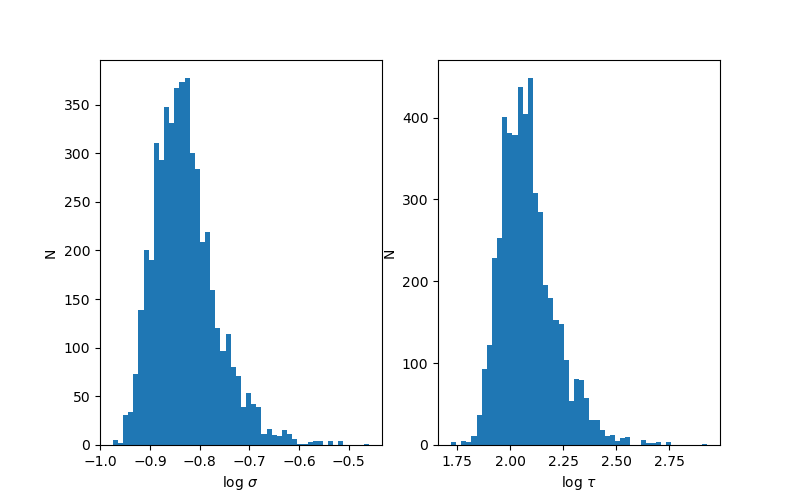

HPD of sigma
low:    0.129 med    0.146 hig    0.169
HPD of tau
low:   92.592 med  117.121 hig  161.699
None


In [7]:
cont.show_hist(bins=50)

conthpd = cont.get_hpd()
print(conthpd)
#truths
# true_sigma = np.log(sigma)
# true_tau = np.log(tau)

load MCMC chain from DRW Results/Consistency Check/chain-d4000-c5-iter2.dat
HPD of sigma
low:    0.130 med    0.147 hig    0.169
HPD of tau
low:   85.946 med  109.948 hig  146.624


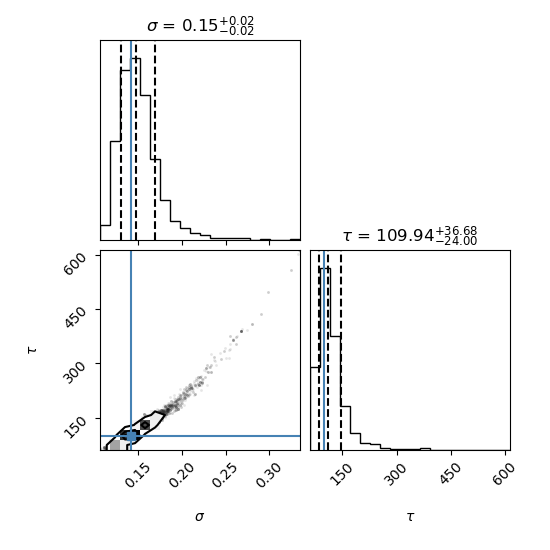

In [101]:
import pandas as pd
import corner
import numpy as np
%matplotlib widget

tau = 100
sf = 0.2
sigma = sf/np.sqrt(2)
chain = "DRW Results/Consistency Check/chain-d4000-c5-iter2.dat"
df = pd.read_csv(chain,sep=' ',header=None)
# print(df)
# 18, 50, 84
figure = corner.corner(np.exp(df.values),
    quantiles=[0.16,0.5,0.84],
    show_titles=True,
    truths=[sigma,tau],
    labels=['$\sigma$',r'$\tau$'])

cont.load_chain(chain)


109.94104472127573
120.19650392996752


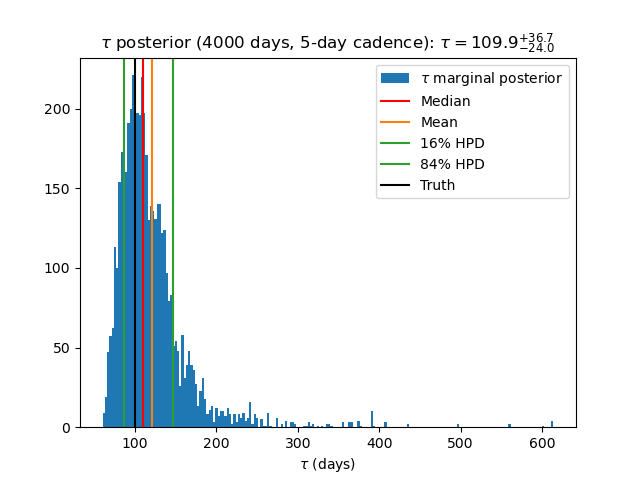

In [147]:
import matplotlib.pyplot as plt

df2 = pd.read_csv("DRW Results/Consistency Check/logp-d4000-c5-iter2.dat",sep=' ',header=None)
df1 = pd.read_csv("DRW Results/Consistency Check/chain-d4000-c5-iter2.dat",sep=' ',header=None)
# np.exp(np.median(df.values[:,1]))
# max_prob_index = np.where(df2[3] == np.max(df2[3]))[0][0]
# np.exp(df1[1][max_prob_index])
plt.figure()
plt.hist(np.exp(df1[1]),bins=200,label=r'$\tau$ marginal posterior')
med = np.median(np.exp(df1[1]))
mean = np.mean(np.exp(df1[1]))
plt.axvline(med,c='red',label='Median')
plt.axvline(mean,c='tab:orange',label='Mean')
print(med)
print(mean)
plt.xlabel(r'$\tau$ (days)')

dens_intervals = np.exp(np.quantile(df1[1],(0.16,0.5,0.84)))
plt.axvline(dens_intervals[0],label='16% HPD',c='tab:green')
# plt.axvline(dens_intervals[1],label='50% HPD',c='tab:green')
plt.axvline(dens_intervals[2],label='84% HPD',c='tab:green')
plt.axvline(tau,label='Truth',c='k')
plt.legend()
plt.title('$\\tau$ posterior (4000 days, 5-day cadence): $\\tau = {:.1f}^{{+{:.1f}}}_{{-{:.1f}}}$'.format(med,dens_intervals[2]-med,med-dens_intervals[0]))

plt.show()
plt.savefig('tau-posterior-iter2.pdf')

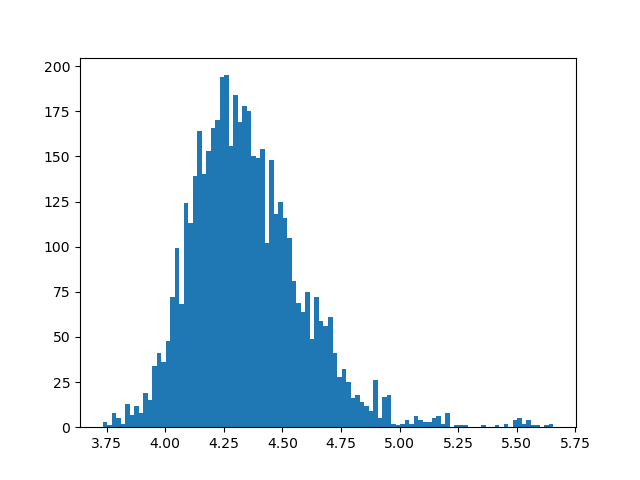

In [129]:
df = pd.read_csv("DRW Results/Multi Curve/chain-d4000-c10-iter2.dat",sep=' ',header=None)

plt.figure()
plt.hist(df[1],bins=100)
plt.show()

# Previous attempts

In [ ]:
# covariance matrix
S = np.zeros((len(t),len(t)))
for i in range(0,len(t)):
    for j in range(0,len(t)):
        S[i,j] = sigma**2 * np.exp(-np.abs(t[i] - t[j]) / tau)

# response matrix L (actually a column vector)
L = np.ones((len(y), 1))
# linear coefficient representing the light curve mean
q = mean_mag
C = S + np.eye((len(S)))

C_inverse = np.linalg.inv(C)
bracket = np.matmul(np.matmul(L.T, C_inverse), L)
bracket_inverse = np.linalg.inv(bracket)
rh_term = np.matmul(
    np.matmul(np.matmul(np.matmul(C_inverse, L), bracket_inverse), L.T), C_inverse)
C_perp_inverse = C_inverse - rh_term

likelihood = (np.linalg.det(C))**(-0.5) * np.linalg.det(bracket)**(-0.5) * np.exp(- np.matmul(np.matmul(y.T,C_perp_inverse),y) / 2)

In [87]:
# idk how Bayesian model fitting will work for a damped random walk... but anyway
import scipy.stats as sts
import dynesty
# from dynesty import plotting as dyplot

def model(time_scale,amp):
    sigma = amp*np.sqrt(time_scale/2)
    t=0
    s = np.zeros(2000)
    while t < 2000:
        if t == 0:
            s[t] = np.random.normal(loc=0,scale=sigma) #for the 0th point, draw from Gaussian deviate of width sigma
            t = t + 1
            # print('Here! t = ' + str(t))
        else:
            s[t] = s[t-1]*np.exp(-delta_t/time_scale) + np.random.normal(loc=0,scale=sigma*np.sqrt(1-np.exp(-2*delta_t/time_scale)))
            t = t + 1
    return s + 18
            # print('Here! t = ' + str(t))

def prior_transform(uTheta):
    uTime_scale, uAmp = uTheta
    time_scale = 150*uTime_scale # uniform between 0 and 150
    amp = 0.1*uAmp # uniform between 0 and 0.1
    return time_scale, amp

def lnlike(Theta):
    time_scale, amp = Theta
    y_val = model(time_scale,amp)
    return sum(sts.norm.logpdf(y,loc=y_val,scale=sigma))
    
dsampler = dynesty.DynamicNestedSampler(lnlike, prior_transform, ndim=2)
dsampler.run_nested(print_progress=True)


    

4568it [1:37:53,  3.09s/it, batch: 0 | bound: 867 | nc: 228 | ncall: 817007 | eff(%):  0.559 | loglstar:   -inf < 975.646 <    inf | logz: 962.771 +/-  0.217 | dlogz: 294.575 >  0.010] Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/dynesty/dynesty.py", line 982, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "/var/folders/f0/bpm69fqn0jl4w0k0w01_lftw0000gn/T/ipykernel_67928/3030410087.py", line 29, in lnlike
    y_val = model(time_scale,amp)
  File "/var/folders/f0/bpm69fqn0jl4w0k0w01_lftw0000gn/T/ipykernel_67928/3030410087.py", line 16, in model
    s[t] = s[t-1]*np.exp(-delta_t/time_scale) + np.random.normal(loc=0,scale=sigma*np.sqrt(1-np.exp(-2*delta_t/time_scale)))
KeyboardInterrupt
4568it [1:37:53,  1.29s/it, batch: 0 | bound: 867 | nc: 228 | ncall: 817007 | eff(%):  0.559 | loglstar:   -inf < 975.646 <    inf | logz: 962.771 +/-  0.217 | dlogz: 294.575 >  0.010]

Exception while calling loglikelihood function:
  params: [5.52139114e+01 1.19443173e-02]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [72]:
(s*s).mean()

0.02071170391231226

In [74]:
s.var()

0.02050307097315799

array(0.00088429)